#Global GDP Data Tear Down (Part 1: Exploration)

This notebook is meant to be the first is a series meant to demonstrate model generation from a dataset in Python by:

1. doing an initial exploration of the data (this notebook)
2. extracting patterns in the data using similarity measures
3. using machine learning to create a predictive model using this information

The specific types of features we'll be looking for are relationships between multiple countries. We can use this information to build up clusters of countries by looking for mutually connected sets. 

First lets setup some utility functions for the rest of the notebook. Feel free to skip the next code block, hopefully the function names are descriptive enough to get what they're doing later.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
from pandas.tools.plotting import bootstrap_plot, scatter_matrix  # also autocorrelation_plot, andrews_curves, lag_plot
#import mpld3
#from geopy.distance import vincenty
import json
from pymongo import MongoClient
from time import sleep
import dateutil
%pylab inline
#mpld3.enable_notebook()

#beautiful function from http://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-th
def smooth(y, box_pts=0):
  if box_pts==0:
    box_pts = np.ceil(y.__len__()*.01)
  box = np.ones(box_pts)/box_pts
  y_smooth = np.convolve(y, box, mode='same')
  return y_smooth

def invert_colors(ax, grid=True):
    ax.patch.set_facecolor('black')
    if grid:
        ax.grid(color='w')
    return ax

def calc_norm(x):
    #x is a pandas series object
    x_no_offset = x-x.copy().dropna().min()
    return x_no_offset/float(max(x_no_offset))

def stringify(a):
        return [str(c).replace('.','') for c in a]

Populating the interactive namespace from numpy and matplotlib


## Initial Exploration
### Load the Data

Data will be downloaded from [Github Datasets](http://www.github.com/datasets/) where you can find a bunch of easily accessbile well formatted data sources for common things like population and [Gross Domestic Product](http://en.wikipedia.org/wiki/Gross_domestic_product) (GDP).
After loading the data, let us print the first few lines to check its structure.

In [2]:
gdp = pandas.DataFrame.from_csv("https://raw.githubusercontent.com/datasets/gdp/master/data/gdp.csv")
country_list = list(pandas.DataFrame.from_csv("https://raw.githubusercontent.com/datasets/country-codes/master/data/country-codes.csv")['ISO3166-1-Alpha-3'])
pops = pandas.DataFrame.from_csv("https://raw.githubusercontent.com/datasets/population/master/data/population.csv")
#next create weights for countries based on the percentage of the global population contained
pops_weights = pops.pivot(
    index='Year',
    columns="Country Code",
    values="Value"
).apply(
    lambda x: x / x.WLD,
    axis = 1
)
gdp.rename(columns={"Value":"GDP"}, inplace=True)
gdp['Country Name'] = gdp.index

#save regional gdps seperately and remove from main variable
regional_gdp = gdp.copy()[[(c not in country_list) & (c != 'WLD') for c in gdp['Country Code']]]
world_gdp = gdp.copy()[gdp['Country Code']=="WLD"].pivot(index="Year", columns="Country Code", values= "GDP")
world_gdp.rename(columns={'WLD':'GDP'})
gdp = gdp[[c in country_list for c in gdp['Country Code']]]

#add population column to gdp data
gdp = gdp.merge(pops, on=['Country Code', 'Year'])
gdp = gdp.rename(columns={'Value':'Population'})

#world population
wld_pops = pops[pops['Country Code']=='WLD']
wld_pops.index = wld_pops.Year
wld_pops = pandas.DataFrame(wld_pops['Value']).rename(columns={'WLD':'population'})
world_gdp = world_gdp.merge(wld_pops, left_index=True, right_index=True)
world_gdp = world_gdp.rename(columns={'Value':'Population'})

#calc gdp per capita
gdp['GDP per capita'] = gdp['GDP']/gdp['Population']
#world_gdp['GDP per capita'] = world_gdp['GDP']/world_gdp['Population']

gdp.head()

Country Code  Year           GDP Country Name  Population  GDP per capita
0          AFG  1960  5.377778e+08  Afghanistan     8774440       61.289132
1          AFG  1961  5.488889e+08  Afghanistan     8953544       61.304093
2          AFG  1962  5.466667e+08  Afghanistan     9141783       59.798693
3          AFG  1963  7.511112e+08  Afghanistan     9339507       80.423002
4          AFG  1964  8.000000e+08  Afghanistan     9547131       83.794812

### Tabular Structure Check
To check if the data values we loaded make sense we can look at the ranges and other statistics for each column. As expected, count is the same for every column, since every column has 8080 entries. We can see we have data from 1960 to 2010 by the min and max of the Year column. We can also get a sense for the range of GDP, GDP per capita, and population.

In [3]:
gdp.describe()

Year           GDP    Population  GDP per capita
count  8759.000000  8.759000e+03  8.759000e+03     8759.000000
mean   1990.065761  1.487301e+11  2.920497e+07     6984.764591
std      15.300649  7.827046e+11  1.129357e+08    14134.070935
min    1960.000000  8.824746e+06  9.004000e+03       35.367728
25%    1978.000000  1.153659e+09  1.078783e+06      448.919265
50%    1992.000000  6.087003e+09  5.241914e+06     1535.988732
75%    2003.000000  4.124583e+10  1.615858e+07     6333.649099
max    2014.000000  1.741900e+13  1.364270e+09   193892.322258

In [4]:
startYear = int(gdp.describe().ix['min','Year'])
endYear = int(gdp.describe().ix['max','Year'])

Let's check a few top 10's

In [5]:
print('Top 10 GDP '+str(endYear))
gdp[gdp['Year']==endYear].sort('GDP', ascending=False).head(10)

Top 10 GDP 2014


Country Code  Year           GDP        Country Name  Population  \
8369          USA  2014  1.741900e+13       United States   318857056   
1727          CHN  2014  1.036011e+13               China  1364270000   
4076          JPN  2014  4.601461e+12               Japan   127131800   
3014          DEU  2014  3.852556e+12             Germany    80889505   
8314          GBR  2014  2.941886e+12      United Kingdom    64510376   
2804          FRA  2014  2.829192e+12              France    66201365   
1128          BRA  2014  2.346118e+12              Brazil   202033670   
3967          ITA  2014  2.144338e+12               Italy    61336387   
3654          IND  2014  2.066902e+12               India  1267401849   
6559          RUS  2014  1.860598e+12  Russian Federation   143819569   

      GDP per capita  
8369    54629.495168  
1727     7593.881891  
4076    36194.415613  
3014    47627.392078  
8314    45603.292367  
2804    42736.158675  
1128    11612.510802  
3967    34960.295021  
3654     1630.818512  
6559    12937.028915

In [6]:
print('Top 10 GDP per capita '+str(endYear))
gdp[gdp['Year']==endYear].sort('GDP per capita', ascending=False).head(10)

Top 10 GDP per capita 2014


Country Code  Year           GDP      Country Name  Population  \
5922          NOR  2014  5.001031e+11            Norway     5136475   
4731          MAC  2014  5.550153e+10  Macao SAR, China      575481   
6505          QAT  2014  2.118168e+11             Qatar     2267916   
384           AUS  2014  1.453770e+12         Australia    23490736   
2218          DNK  2014  3.419516e+11           Denmark     5639565   
7617          SWE  2014  5.705913e+11            Sweden     9689555   
6957          SGP  2014  3.078719e+11         Singapore     5469700   
8369          USA  2014  1.741900e+13     United States   318857056   
3844          IRL  2014  2.459207e+11           Ireland     4612719   
3599          ISL  2014  1.707100e+10           Iceland      327589   

      GDP per capita  
5922    97363.093254  
4731    96443.727122  
6505    93397.091533  
384     61886.958785  
2218    60634.394272  
7617    58887.251908  
6957    56286.799493  
8369    54629.495168  
3844    53313.612374  
3599    52111.043103

In [7]:
print('Top 10 GDP All Time')
gdp.sort('GDP', ascending=False).head(10)

Top 10 GDP All Time


Country Code  Year           GDP   Country Name  Population  \
8369          USA  2014  1.741900e+13  United States   318857056   
8368          USA  2013  1.676805e+13  United States   316497531   
8367          USA  2012  1.616316e+13  United States   314112078   
8366          USA  2011  1.551793e+13  United States   311721632   
8365          USA  2010  1.496437e+13  United States   309347057   
8363          USA  2008  1.471858e+13  United States   304093966   
8362          USA  2007  1.447764e+13  United States   301231207   
8364          USA  2009  1.441874e+13  United States   306771529   
8361          USA  2006  1.385589e+13  United States   298379912   
8360          USA  2005  1.309373e+13  United States   295516599   

      GDP per capita  
8369    54629.495168  
8368    52980.043626  
8367    51456.658728  
8366    49781.357490  
8365    48374.056457  
8363    48401.427340  
8362    48061.537661  
8364    47001.555350  
8361    46437.067117  
8360    44307.920585

In [8]:
print('Top 10 GDP per capita All Time')
gdp.sort('GDP per capita', ascending=False).head(10)

Top 10 GDP per capita All Time


Country Code  Year           GDP   Country Name  Population  \
5323          MCO  2008  6.919241e+09         Monaco       35686   
5322          MCO  2007  5.974372e+09         Monaco       35013   
5326          MCO  2011  6.074884e+09         Monaco       37261   
4632          LIE  2011  5.739706e+09  Liechtenstein       36388   
5324          MCO  2009  5.557245e+09         Monaco       36314   
4633          LIE  2012  5.487773e+09  Liechtenstein       36656   
5325          MCO  2010  5.350675e+09         Monaco       36845   
4629          LIE  2008  5.081480e+09  Liechtenstein       35582   
4631          LIE  2010  5.082339e+09  Liechtenstein       36120   
5321          MCO  2006  4.663488e+09         Monaco       34369   

      GDP per capita  
5323   193892.322258  
5322   170632.956215  
5326   163035.999801  
4632   157736.226846  
5324   153033.131088  
4633   149710.100732  
5325   145221.191568  
4629   142810.405264  
4631   140707.058828  
5321   135688.799881

### High-level View of Data
Tables are a great way to quickly check the integrity of your data and do simple queries, but to build models we need to understand how all the datapoints relate to each other. By discovering and extracting structure across countries, we can normalize the data, producing a clean training set for model generation in a later notebook.

These next charts have a lot going on, so let us look at what is there. For each of these charts a 50 member sample is taken from the data 500 times, with the mean, median, and midrange calculated on each group. Because the number of members per sample is small compared to the size of the full dataset, the mean of a set of samples will vary according to the full probability distribution.

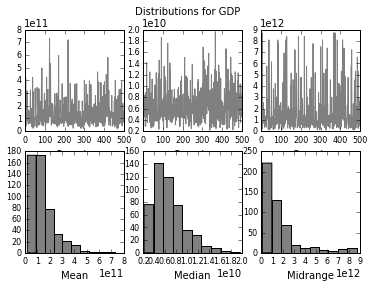

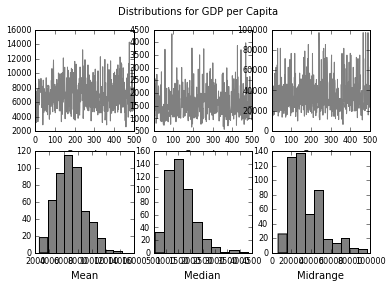

In [9]:
#TODO fix figure size and title
fs = (15,15)
f = bootstrap_plot(gdp['GDP'], size=50, samples=500, color='grey');
f.suptitle("Distributions for GDP")
f = bootstrap_plot(gdp['GDP per capita'], size=50,samples=500, color='grey');
f.suptitle("Distributions for GDP per Capita");

We have 4 numerical columns in our data (GDP, Population, GDP Per Capita, and Year) and there could potentially be interesting patterns and correlations between any set of these variables.

Below we look at all pairs of of these values on a scatter chart. There are patterns and correlations visable in every one of these graphs, but the type of relationship is not always clear and often may rely on more than the two variables shown. Since time probably plays a role in almost every relationship shown, we could try to treat time differently in our graphs such as by creating animations or using color. Hans Rosling has made some interesting animations of global scale time series in this [TED Talk by Hans Rosling](http://www.ted.com/talks/hans_rosling_shows_the_best_stats_you_ve_ever_seen?language=en) I highly recommend. His excitement level alone is inspiring.

Instead lets graph each pair of variables as axis of a scatter graph. The numbers probably won't tell you as much as the shapes in this next one.

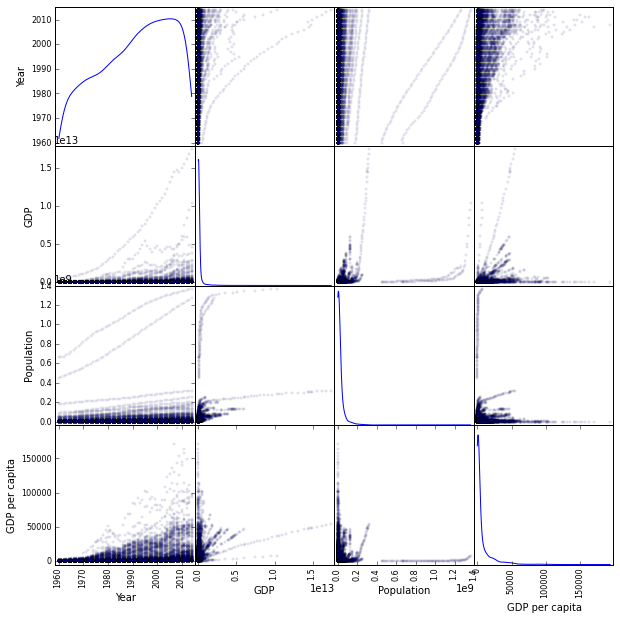

In [10]:
fig = plt.figure()
scatter_matrix(gdp, figsize=(10,10), alpha=0.078, diagonal="kde");
_ = fig;

It is the graph above showing GDP per capita versus time that has the most complex and interesting set of patterns we're going to model in the rest of this analysis. In theory, this graph contains information relating to global production per person, which is a factor of effiency, something worth optimizing.

**Philosophical Motivation:**
I do not believe wealth to be a complete measure of value in this world, 
but I do know that it a measurable one, and therefor potentially a signal that can be modelled and used to better society. Proving techniques like this should motivate investigations into how we can measure other types of value in the world so that they may be better similarly understood. In the future I believe we will measure empathy and stress like we do oil barrel prices today.

## The Whole World

In [11]:
world_gdp.head()

Country Code           WLD  Population
Year                                  
1960          1.368215e+12  3036527378
1961          1.423602e+12  3077623700
1962          1.528570e+12  3130555779
1963          1.644637e+12  3195412654
1964          1.802221e+12  3260817678

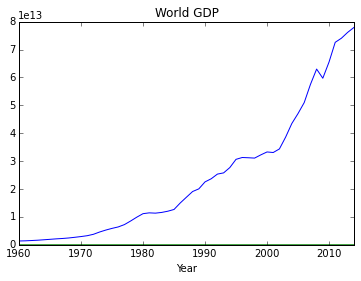

In [12]:
ax = world_gdp.plot(legend=False, title="World GDP");
#ax.patch.set_facecolor('black')

The graph below shows all the world's country's GDPs. Each series/line is a different country. While the large number of lines make it impossible to pick out individual countries (also the reason why a legend was not included), this chart lets us do a high-level view of the data and gives us a sense of the net motion of collection.

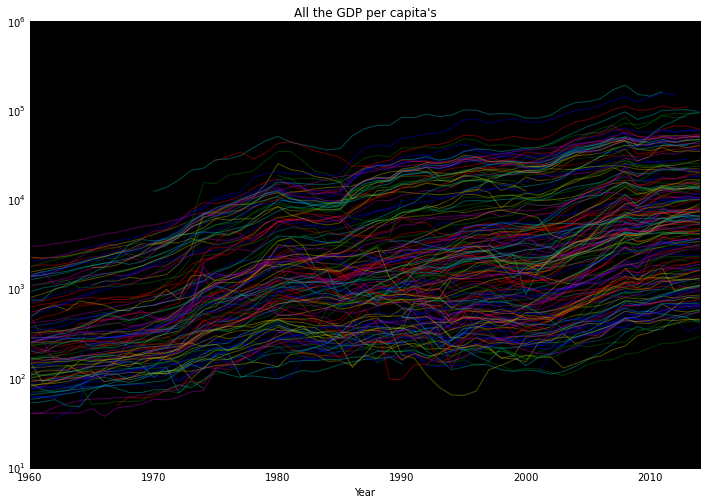

In [13]:
fs = (12,8) #figure size
#lg = False
lgy = True
gdp_by_country = gdp.pivot(index="Year", columns="Country Name", values = "GDP")
#ax = gdp_by_country.plot(logy=lgy, legend=False, figsize=fs, alpha=.4, title='All the GDPs')
ax = invert_colors(ax, grid=False)
gdp_pc_by_country = gdp.pivot(index="Year", columns="Country Name", values = "GDP per capita")
ax = gdp_pc_by_country.plot(logy=lgy, legend=False, figsize=fs, alpha=.4, title="All the GDP per capita's")
ax = invert_colors(ax, grid=False)

Note the data look linear on a logarithmic scale. Using a logarithmic scale causes the size of motion in a signal to be proportional to its size.
Let us dive deeper...

The wide range of values for GDP per capita in the graph above make it hard to tell what group motion looks like. Let us shift and scale each country's data to be between 0 and 1. If we see simultaneous changes across groups of countries, we should suspect some relationship exists to link these countries. If we can isolate those relationships, we may be able to make some meaningful predictions based upon them.

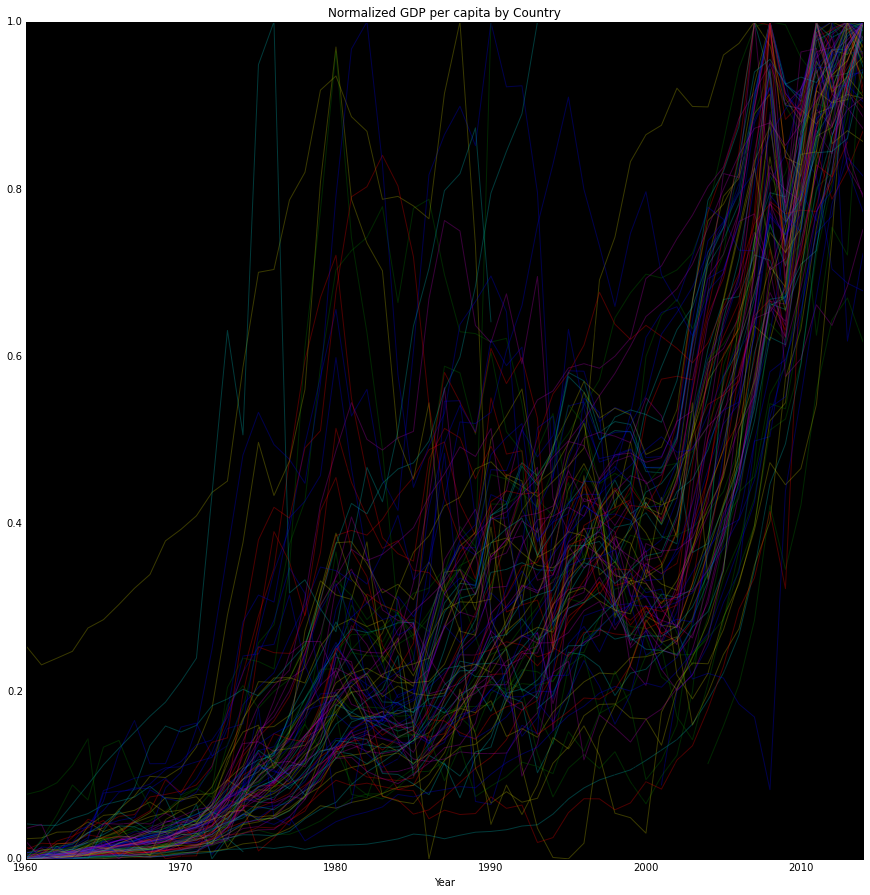

In [14]:
fs = (15,15) #figure size
counter = 0
leg = False #legend
lgy = True
al = .3 #alpha
gdp_by_country_norm = gdp_by_country.apply(calc_norm)
gdp_pc_by_country_norm = gdp_pc_by_country.apply(calc_norm)
#ax = gdp_by_country_norm.plot(legend=leg, logy=lgy, style=st, figsize=fs, alpha=al, title="Normalized GDP by Country")
ax = invert_colors(ax, grid=False)
ax = gdp_pc_by_country_norm.plot(
    legend=leg,
    #logy=lgy,
    figsize=fs, alpha=al, title="Normalized GDP per capita by Country");
ax = invert_colors(ax, grid=False)
counter+=1

The brighter region containing most of the countries indicates this data contains a signal comprised of individual countries and more importantly relationships and interactions between countries.

## Rate of Change

In this section we will look at how GDP values grow and contract over time. Countries sharing growth patterns may be experiencing similar conditions and forces impacting their change in output. The range of these forces can be extremely varied (just speculating: known abundence of natural resources, trade relations, etc.). First we look at the change in gdp from year to year. Then let us look at some graphs of the same data.

In [15]:
diff_gdp = gdp_by_country.apply(lambda x: x.diff()/x, axis=0)
diff_gdp_pc = gdp_by_country.apply(lambda x: x.diff()/x, axis=0)
diff_gdp_pc.dropna()
#diff_gdp.plot(kind="kde")
diff_gdp_pc.tail()

Country Name  Afghanistan   Albania   Algeria   Andorra    Angola  \
Year                                                                
2010             0.216471 -0.009831  0.148854 -0.090711  0.084617   
2011             0.111177  0.074775  0.190201  0.023610  0.207893   
2012             0.126911 -0.044257  0.025743 -0.089333  0.097326   
2013            -0.011110  0.044295  0.027844  0.031677  0.071048   
2014             0.025481  0.033920  0.018124       NaN  0.055079   

Country Name  Antigua and Barbuda  Argentina   Armenia     Aruba  Australia  \
Year                                                                          
2010                    -0.062412   0.182216  0.066126 -0.012655   0.188373   
2011                    -0.004974   0.173270  0.086947  0.045178   0.177800   
2012                     0.062085   0.078759 -0.018500       NaN   0.095384   
2013                    -0.003436   0.023062  0.045376       NaN   0.016628   
2014                     0.053998  -0.151538  0.041390       NaN  -0.073328   

Country Name    ...      Uruguay  Uzbekistan   Vanuatu  Venezuela, RB  \
Year            ...                                                     
2010            ...     0.214067    0.165662  0.129463       0.163490   
2011            ...     0.160083    0.132193  0.115314      -0.244308   
2012            ...     0.066585    0.114473 -0.013365       0.169962   
2013            ...     0.106751    0.098814  0.025050      -0.026794   
2014            ...    -0.000929    0.093358       NaN       0.271838   

Country Name   Vietnam  Virgin Islands (U.S.)  West Bank and Gaza  \
Year                                                                
2010          0.085543                    NaN            0.184549   
2011          0.144664                    NaN            0.148327   
2012          0.130153                    NaN            0.072167   
2013          0.089954                    NaN            0.095912   
2014          0.080463                    NaN            0.020539   

Country Name  Yemen, Rep.    Zambia  Zimbabwe  
Year                                           
2010             0.079182  0.243626  0.137439  
2011             0.005538  0.146057  0.136855  
2012             0.031050  0.048421  0.121563  
2013             0.107907  0.070150  0.075448  
2014                  NaN  0.009068  0.012668  

[5 rows x 204 columns]

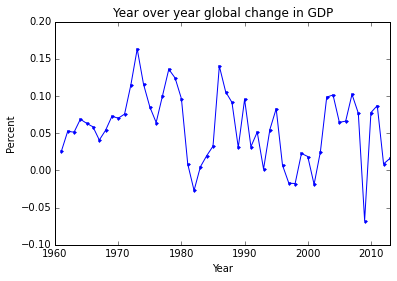

In [16]:
wld_gdp_pc = world_gdp.WLD/world_gdp.Population
diff_wrd_gdp = wld_gdp_pc.diff()/wld_gdp_pc
ax = diff_wrd_gdp.ix[range(1960,2014)].plot(legend=False, style='.-', title="Year over year global change in GDP")
#ax = diff_gdp_pc.ix[range(1960,2014)].sum(axis=1).plot(legend=False, style='.', title="Year over year global change in GDP")
ax.set_ylabel('Percent');
#ax = invert_colors(ax)

In [17]:
diff_gdp_perc_of_wld = gdp_pc_by_country.fillna(method='backfill').apply(
    (lambda x: x.diff()), axis=0
)
diff_gdp_perc_of_wld['WLD'] = wld_gdp_pc
diff_gdp_perc_of_wld.apply(lambda x: x/diff_gdp_perc_of_wld['WLD'])

#.join(wld_gdp_pc, on="Year")
        #/wld_gdp_pc#.diff()
diff_gdp_perc_of_wld['WLD'].head(100);

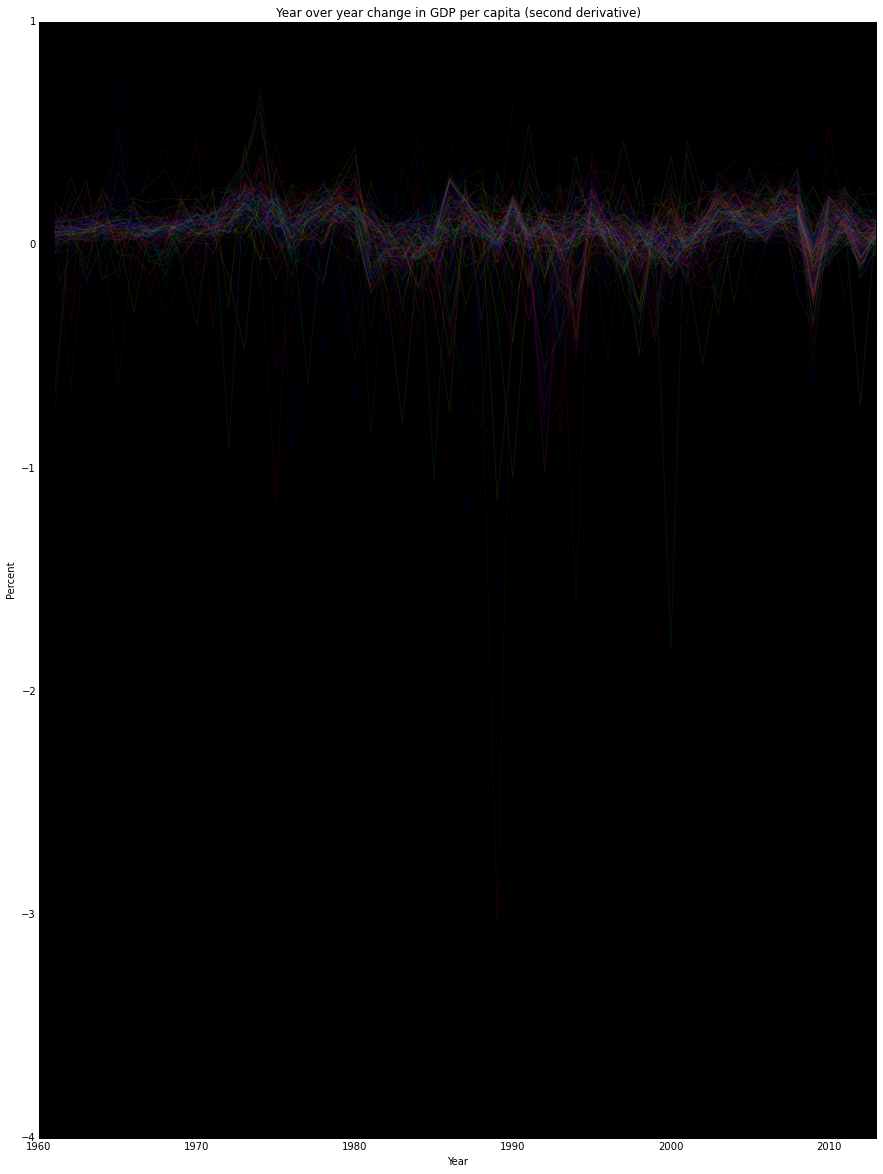

In [18]:
ax = diff_gdp_pc.ix[range(startYear,endYear)].plot(kind='line', style='-', alpha=0.1, figsize=(15,20), ylim=(-4, 1), legend=False, title="Year over year change in GDP per capita (second derivative)")
ax = invert_colors(ax, grid=False)
ax.set_ylabel("Percent");
#savefig('test.png', bbox_inches='tight')

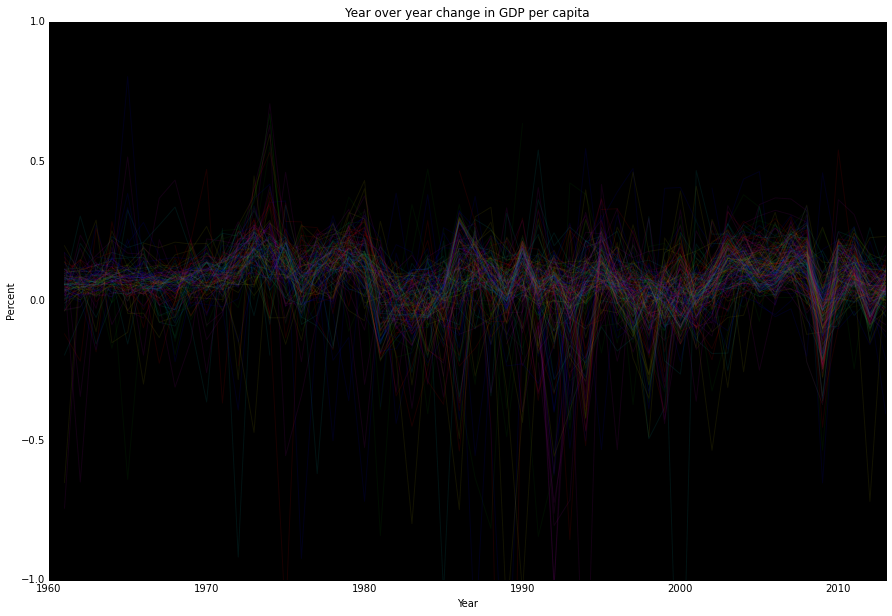

In [19]:
#same graph as last cell but different ylims
ax = diff_gdp_pc.ix[range(startYear,endYear)].plot(kind='line', style='-', alpha=0.1, figsize=(15,10), ylim=(-1, 1), legend=False, title="Year over year change in GDP per capita")
ax = invert_colors(ax, grid=False)
ax.set_ylabel("Percent");
#savefig('test.png', bbox_inches='tight')

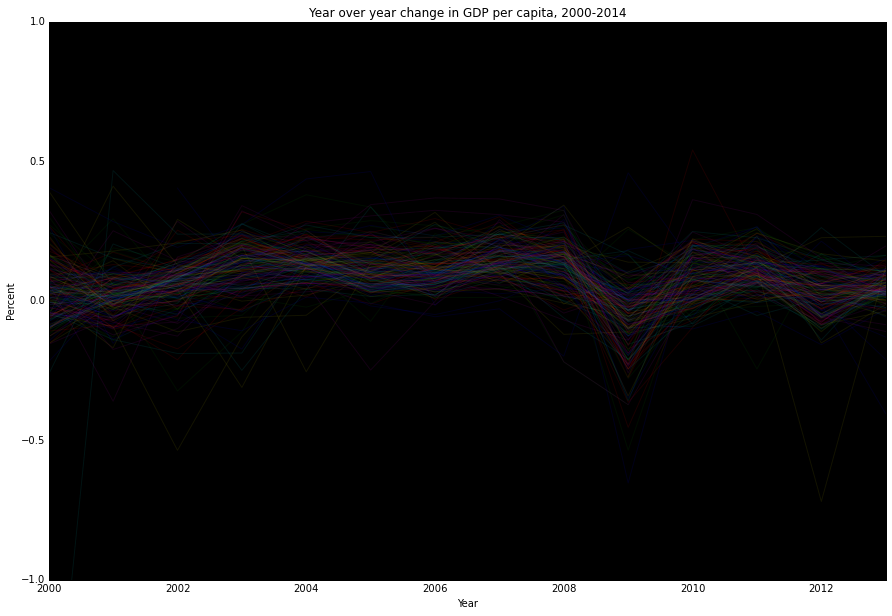

In [20]:
#same graph as last cell but different xlims
ax = diff_gdp_pc.ix[range(2000,endYear)].plot(kind='line', style='-', alpha=0.1, figsize=(15,10), ylim=(-1, 1), legend=False, title="Year over year change in GDP per capita, 2000-2014")
ax = invert_colors(ax, grid=False)
ax.set_ylabel("Percent");
#savefig('test.png', bbox_inches='tight')

I love seeing the whole world moving together like that. Let's talk a little about how this view of the data could be interpreted. A year over year change is  GDP per Capita

So obviously there is some group motion here, but we want to isolate the relationships between countries, so global gdp motion needs to be normalized out, like so:

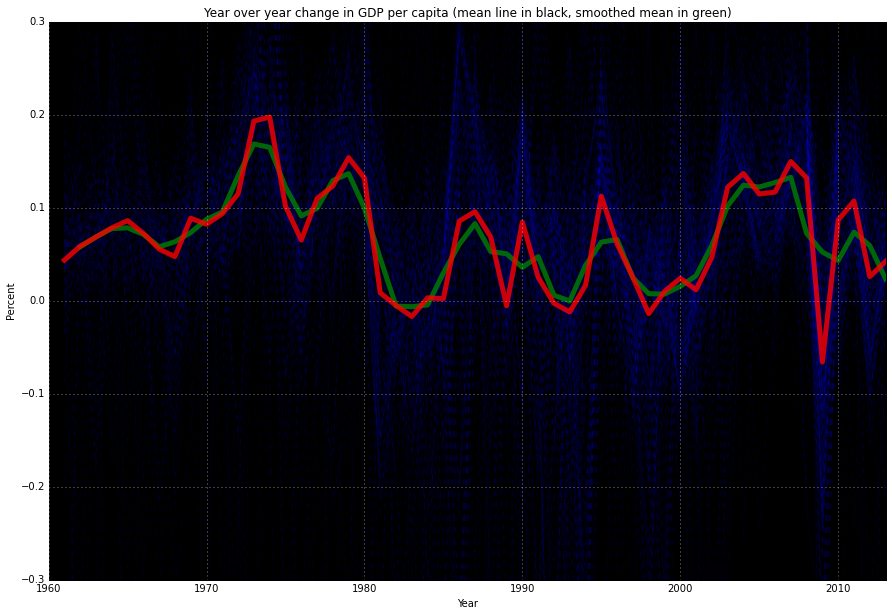

In [21]:
#should we normalize based upon a population weighted mean? probably worth checking out
#same graph as last cell but with mean line drawn
ax = diff_gdp_pc.ix[range(startYear,endYear)].plot(kind='line', style='--b', alpha=0.1, figsize=(15,10), ylim=(-.3,.3), legend=False, title="Year over year change in GDP per capita")
ax = world_gdp.ix[range(startYear,endYear)]['WLD'].plot(kind='line', ax = ax, style='-', linewidth=5, alpha=1, legend=False, title="Year over year change in GDP per capita (mean line in BOLD)")
ax = diff_gdp_pc.ix[range(startYear,endYear)].apply(lambda x: smooth(x, box_pts=3), axis=0).mean(weights=pops_weights, axis=1).plot(kind='line', ax = ax, style='-g', alpha=.8, linewidth=5, ylim=(-.3,.3), legend=False, title="Year over year change in GDP per capita (mean line in BOLD)")
ax = diff_gdp_pc.ix[range(startYear,endYear)].mean(weights=pops_weights, axis=1).plot(kind='line', ax = ax, style='-r', alpha =.8, linewidth=5, ylim=(-.3,.3), legend=False, title="Year over year change in GDP per capita (mean line in black, smoothed mean in green)")
ax = invert_colors(ax, grid=True)
ax.set_ylabel("Percent");
#savefig('test.png', bbox_inches='tight')

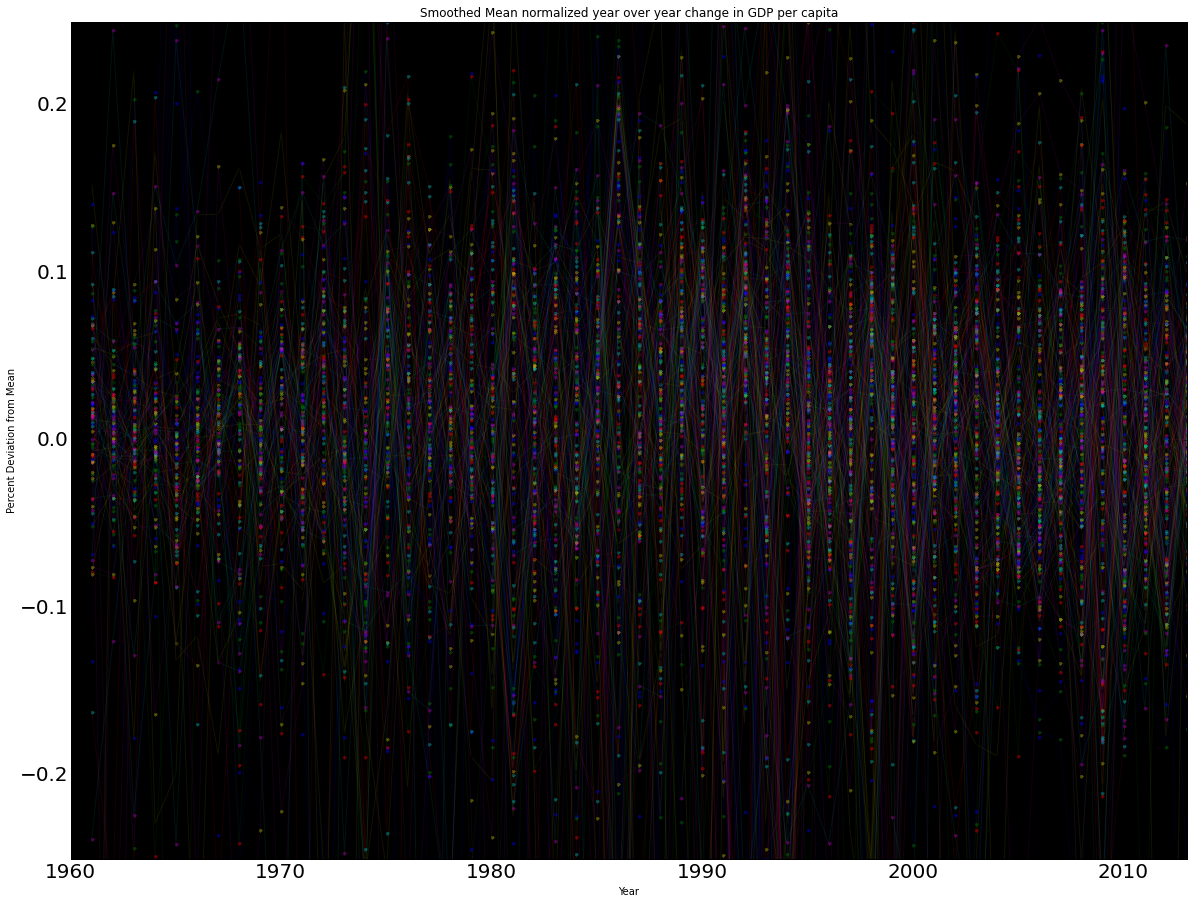

In [22]:
#Remove trend line
#TODO: calc mean based on a windowed outlier reduction
timeRange = range(startYear,endYear)
means = diff_gdp_pc.copy().mean(weights=pops_weights, axis=1)
stripped_diff_gdp = diff_gdp_pc.ix[timeRange].copy().apply(lambda x: x - means)

ax = stripped_diff_gdp.ix[range(startYear,endYear)].plot(kind='line', style='-', alpha=0.1, figsize=(20,15), ylim=(-.25,.25), legend=False, title="Mean normalized year over year change in GDP per capita")
stripped_diff_gdp.ix[range(startYear,endYear)].plot(kind='line', style='.', alpha=.4, figsize=(20,15), fontsize=20, ylim=(-.25,.25), legend=False, title="Smoothed Mean normalized year over year change in GDP per capita", ax=ax)
#ax = stripped_diff_gdp.ix[range(startYear,endYear)].mean(axis=1).plot(kind='line', ax = ax, style='-', linewidth=5, alpha=1, ylim=(-.5,.5), legend=False)
ax = invert_colors(ax, grid=False)
ax.set_ylabel("Percent Deviation from Mean");
#savefig('test.png', bbox_inches='tight')

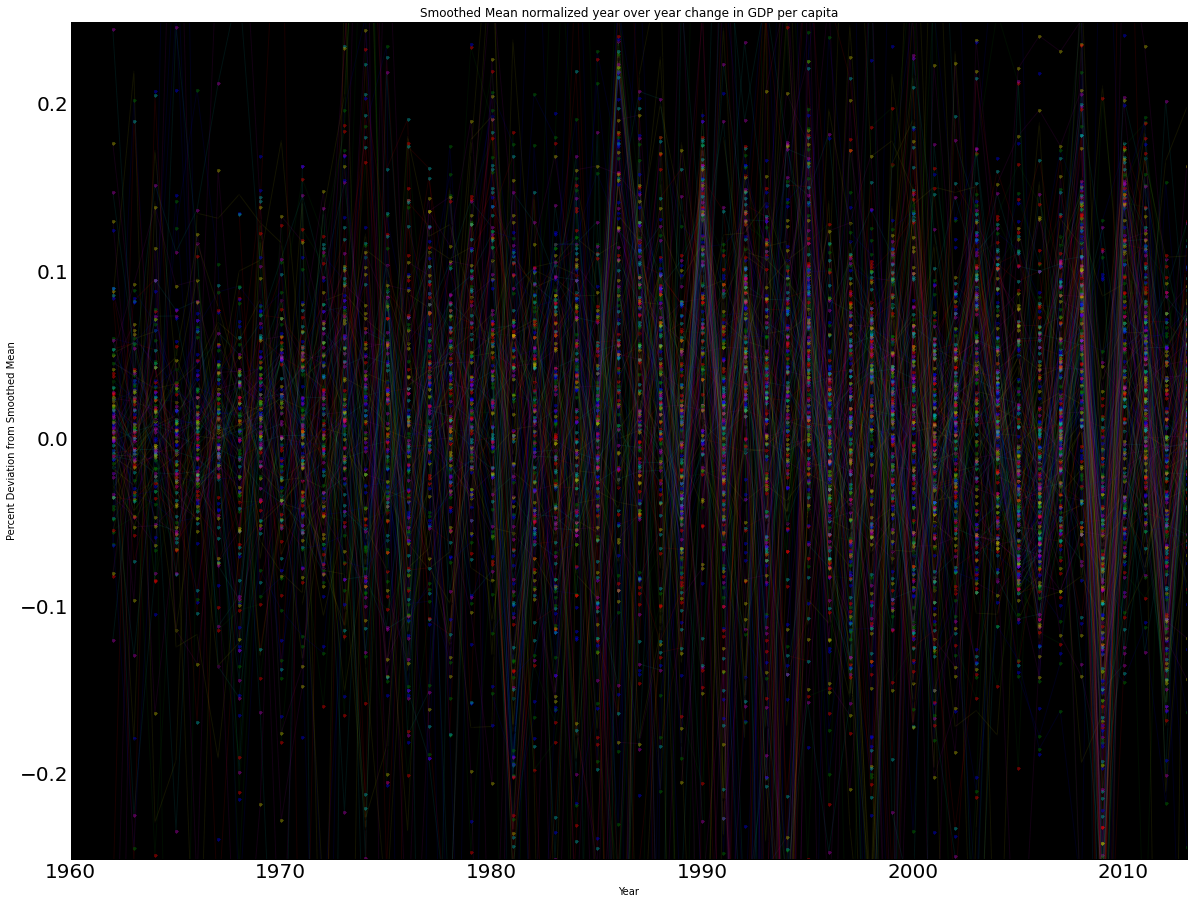

In [23]:
smooth_means = diff_gdp_pc.apply(lambda x: smooth(x, box_pts=3), axis=0).mean(weights=pops_weights, axis=1)

smooth_stripped_diff_gdp = diff_gdp_pc.ix[timeRange].copy().apply(lambda x: x - smooth_means)

ax = smooth_stripped_diff_gdp.ix[range(startYear,endYear)].plot(kind='line', style='-', alpha=0.1, figsize=(20,15), fontsize=20, ylim=(-.25,.25), legend=False, title="Smoothed Mean normalized year over year change in GDP per capita")
smooth_stripped_diff_gdp.ix[range(startYear,endYear)].plot(kind='line', style='.', alpha=.4, figsize=(20,15), fontsize=20, ylim=(-.25,.25), legend=False, title="Smoothed Mean normalized year over year change in GDP per capita", ax=ax)
#ax = smooth_stripped_diff_gdp.ix[range(startYear,endYear)].mean(axis=1).plot(kind='line', ax = ax, style='-', linewidth=5, alpha=1, ylim=(-.5,.5), legend=False)
ax = invert_colors(ax, grid=False)
ax.set_ylabel("Percent Deviation from Smoothed Mean");

#Sneak peak at relationships
Above we took the raw GDP per captia values, looked at how they are changing over time, and tried to isolate changes that were specific to subsets of the globe rather than global changes. In the process, we also isolated global changes which we will later use as another feature for model generation. We can look for correlations in the normalized signal above to determine a type of similarity between countries relative GDP per captita changes. I'm going to keep the detail of explanation light in this section, with the intent of providing a more clear explanation in the next notebook on patterns and similarity metrics.

For the moment let us look at the exponentially-weighted moving correlation of our normalized signal. This metric will look for similar changes across countries, weighting the most recent values as expontentially more signficant.

In [24]:
ecorr_stripped_diff_gdp = pandas.stats.moments.ewmcorr(stripped_diff_gdp, span=10)

In [25]:
countries = ['United States','South Africa','Ukraine']

In [26]:
for c in countries:
    #see who's most like a United States
    print(ecorr_stripped_diff_gdp.ix[endYear, c].dropna().sort(inplace=False, ascending=False).head())
    print('')

Country Name
United States       1.000000
Belize              0.930742
Bahamas, The        0.909081
Puerto Rico         0.905937
Marshall Islands    0.891883
Name: United States, dtype: float64

Country Name
South Africa    1.000000
Lesotho         0.957033
Namibia         0.904755
Swaziland       0.863037
Botswana        0.760052
Name: South Africa, dtype: float64

Country Name
Ukraine                1.000000
Somalia                0.990478
Russian Federation     0.900533
Iraq                   0.836465
Trinidad and Tobago    0.831378
Name: Ukraine, dtype: float64



In [27]:
ecorr_stripped_diff_gdp.ix[endYear].sum().sort(inplace=False, ascending=False)

Country Name
Isle of Man              19.419917
Faeroe Islands           15.343661
Sao Tome and Principe    15.193803
Malta                    15.082716
Germany                  14.618055
French Polynesia         14.616693
France                   14.596038
Austria                  14.559103
Belgium                  14.543973
Netherlands              14.053831
Morocco                  13.939221
Denmark                  13.527025
Portugal                 13.223294
Italy                    12.896747
Puerto Rico              12.894143
Comoros                  12.296648
Tunisia                  12.167382
Luxembourg               12.138923
Cameroon                 11.989172
New Caledonia            11.982493
Switzerland              11.637755
Slovenia                 11.612943
Finland                  11.065837
Spain                    10.934014
Bangladesh               10.904407
Timor-Leste              10.898567
El Salvador              10.795955
Djibouti                 10.735398
Benin  

In [28]:
ecorr_stripped_diff_gdp.to_frame(False).head()

Year                       1960  1961  1962      1963      1964      1965  \
Country Name Country Name                                                   
Afghanistan  Afghanistan    NaN   NaN     1  1.000000  1.000000  1.000000   
             Albania        NaN   NaN   NaN       NaN       NaN       NaN   
             Algeria        NaN   NaN     1  0.996243  0.891562  0.846123   
             Andorra        NaN   NaN   NaN       NaN       NaN       NaN   
             Angola         NaN   NaN   NaN       NaN       NaN       NaN   

Year                           1966      1967      1968      1969    ...     \
Country Name Country Name                                            ...      
Afghanistan  Afghanistan   1.000000  1.000000  1.000000  1.000000    ...      
             Albania            NaN       NaN       NaN       NaN    ...      
             Algeria       0.494941  0.483524 -0.132263 -0.138699    ...      
             Andorra            NaN       NaN       NaN       NaN    ...      
             Angola             NaN       NaN       NaN       NaN    ...      

Year                           2005      2006      2007      2008      2009  \
Country Name Country Name                                                     
Afghanistan  Afghanistan   1.000000  1.000000  1.000000  1.000000  1.000000   
             Albania      -0.355550 -0.037412 -0.124014 -0.199244 -0.330773   
             Algeria      -0.886885 -0.474473 -0.558763 -0.728594 -0.809908   
             Andorra       0.064624  0.226839  0.050442  0.476573  0.322426   
             Angola        0.661208  0.470796  0.438514  0.396655 -0.416776   

Year                           2010      2011      2012      2013      2014  
Country Name Country Name                                                    
Afghanistan  Afghanistan   1.000000  1.000000  1.000000  1.000000  1.000000  
             Albania      -0.326707 -0.247275 -0.268278 -0.333699 -0.333699  
             Algeria      -0.691961 -0.724857 -0.727777 -0.544478 -0.544478  
             Andorra       0.116721  0.150789  0.113530 -0.073265 -0.073265  
             Angola       -0.439372 -0.437534 -0.442944 -0.219325 -0.219325  

[5 rows x 55 columns]

In [29]:
#prep stripped_diff_gdp
stripped_diff_gdp_T = stripped_diff_gdp.copy().T
diff_gdp_T = diff_gdp.copy().T
gdp_means = pandas.DataFrame(means, columns=["global mean (each country=1) gdp percent change"])
gdp_smoothed_means = pandas.DataFrame(smooth_means, columns=["global smoothed "])


In [30]:
gdp_pc = gdp.pivot(index="Year",columns="Country Name", values="GDP per capita")

## Store all the things
Now that we've distilled some features from our simple dataset, we can store them in MongoDB so that we can retrieve and utilize them in future notebooks.

In [31]:
#save things to mongo
dataframes_to_save = ['gdp_pc', 'diff_gdp_T','stripped_diff_gdp_T','diff_gdp','diff_gdp_pc','stripped_diff_gdp','smooth_stripped_diff_gdp','gdp_means']
db = MongoClient('mongodb')
col_base = 'gdp.analysis.exploratory.'
for t in dataframes_to_save:
    df = eval(t).copy()
    df.index = stringify(df.index)
    df.columns = stringify(df.columns)
    d = df.to_dict()
    col = eval('db.'+col_base+t)
    col.drop()
    col.insert(d)
    #col.insert_one(d)
    
#panels have to be saved differently
panels_to_save = ['ecorr_stripped_diff_gdp']
for p in panels_to_save:
    col = eval('db.'+col_base+p)
    col.drop()
    panel = eval(p).copy()
    panel.items = stringify(panel.items)
    panel.major_axis = stringify(panel.major_axis)
    panel.minor_axis = stringify(panel.minor_axis)
    for i in panel.items:
        col.insert({'item':i, 'data': panel[str(i)].to_dict()})